<a href="https://colab.research.google.com/github/luckeydoo6/ExoPlanet/blob/main/Exoplanet_Transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii

In [2]:
from google.colab import files
uploaded = files.upload()

Saving HD_189733.txt to HD_189733.txt


In [3]:
dat = astropy.io.ascii.read("HD_189733.txt")

In [4]:
print(dat)

     col1      col2   col3  col4
------------- ------ ------ ----
2453897.75327 1.0004 0.0024    1
2453897.75417 0.9971 0.0024    1
2453897.75517 1.0031 0.0024    1
2453897.75607 1.0056 0.0024    1
2453897.75707 1.0059 0.0024    1
2453897.75797 1.0034 0.0024    1
2453897.75887 0.9969 0.0024    1
2453897.75987 0.9984 0.0024    1
2453897.76077 1.0012 0.0024    1
2453897.76227 0.9959 0.0024    1
          ...    ...    ...  ...
2453897.94268 1.0002 0.0015    1
2453897.94358 1.0009 0.0015    1
2453897.94448 1.0012 0.0015    1
2453897.94548  0.998 0.0015    1
2453897.94638 1.0019 0.0015    1
2453897.94728 1.0003 0.0015    1
2453897.94828 0.9984 0.0015    1
2453897.94918 0.9988 0.0015    1
2453897.95058 1.0018 0.0015    1
2453897.95158 1.0026 0.0015    1
2453897.95248 1.0001 0.0015    1
Length = 202 rows


Text(0, 0.5, 'Normalize Flux')

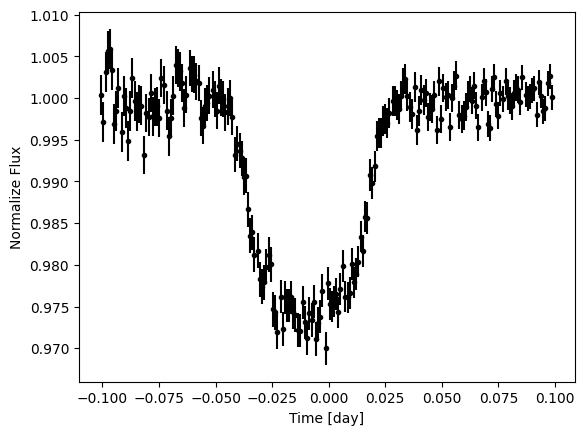

In [5]:
#Taking the data and signing them to different values to make the graph
time = dat["col1"] - np.median(dat["col1"])
flux = dat["col2"]
err = dat["col3"]
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")

In [6]:
#Setting up model values so that we can make a model
def box_model(t, center_time, duration, depth, delta_flux):
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0))
  f[ind] = 1.0 + delta_flux
  return(f)

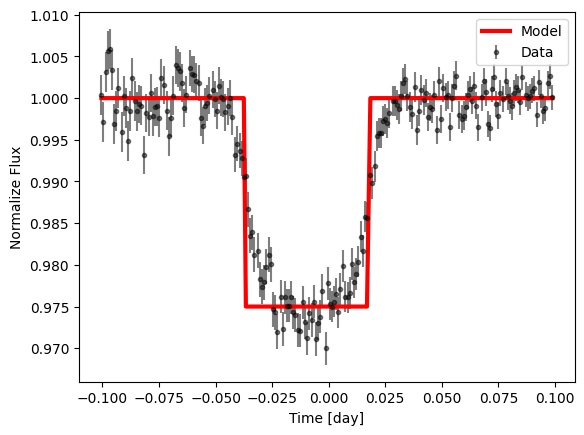

In [7]:
#We can set different values for our model and compare it to the data
center_time, duration, depth, delta_flux = -0.01, 0.055, 0.025, 0.0
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [8]:
# define a function to calculate reduced chi square to measure goodness of fit.
def calc_reduced_Chi2(O, C, err, n, m):
  Chi2 = np.sum((O - C)**2 / err**2)
  reduced_Chi2 = Chi2 / (n - m)
  return(reduced_Chi2)

In [9]:
# prints reduced chi square value
print("reduced Chi2 = ", calc_reduced_Chi2(flux, model, err, len(time), 4.0))

reduced Chi2 =  3.1510584139817586


In [10]:
#Setting up next graph to plot
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux = theta
    model = box_model(time, center_time, duration, depth, delta_flux)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [11]:
#Setting up parameters to take a look at a specific part of graph and see its "step numbers"
def log_prior(theta):
    center_time, duration, depth, delta_flux = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 and -0.1 < delta_flux < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [12]:
! pip install -U emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 688.1 kB/s eta 0:00:00


In [13]:
#Setting parameters for the array
import emcee

pos = np.array([-0.01, 0.055, 0.025, 0.0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 10000, progress=True);


100%|██████████| 10000/10000 [02:19<00:00, 71.44it/s]


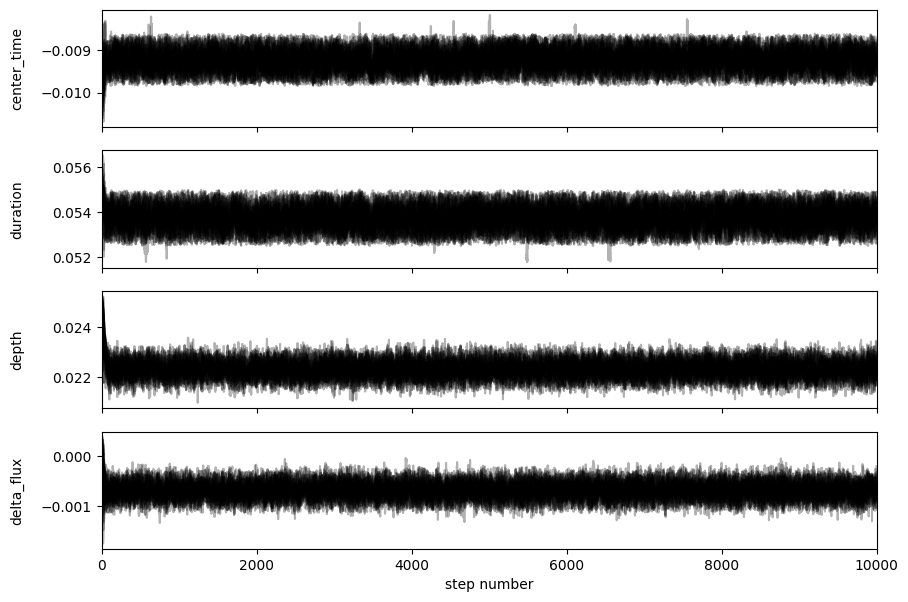

In [14]:
#Plotting the different data gathered
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [32]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(3136, 5)


In [33]:
! pip install corner


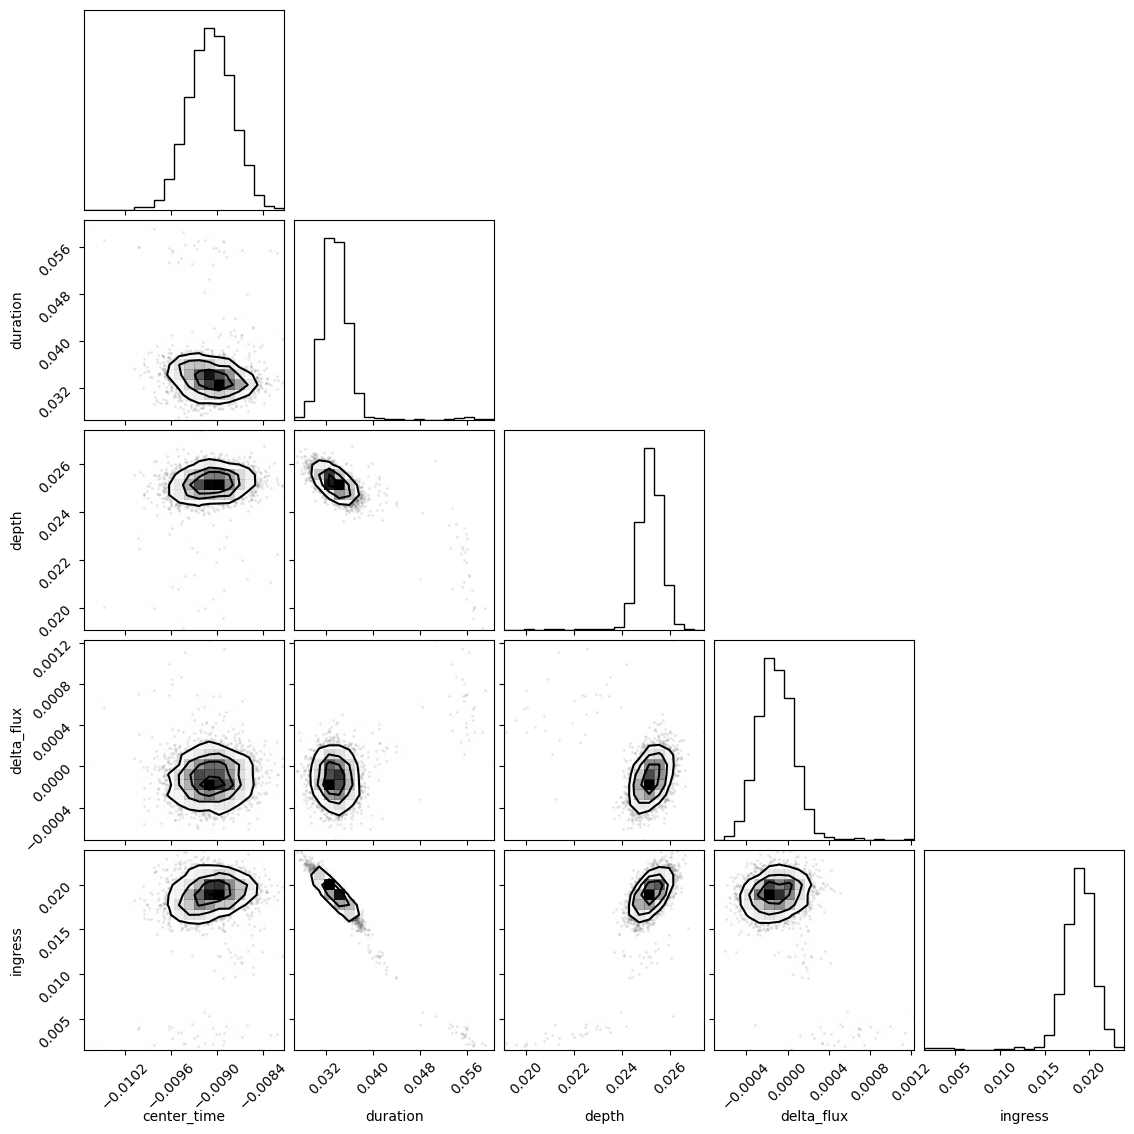

In [34]:
import corner
fig = corner.corner(flat_samples, labels=labels);

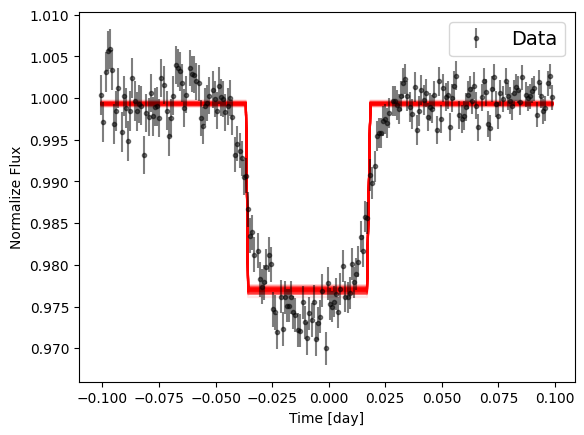

In [18]:
#The code finds the best fir model, closest to chi^2
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    center_time, duration, depth, delta_flux = sample
    plt.plot(time, box_model(time, center_time, duration, depth, delta_flux), color="red", alpha=0.1)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.legend(fontsize=14)
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux");


In [19]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

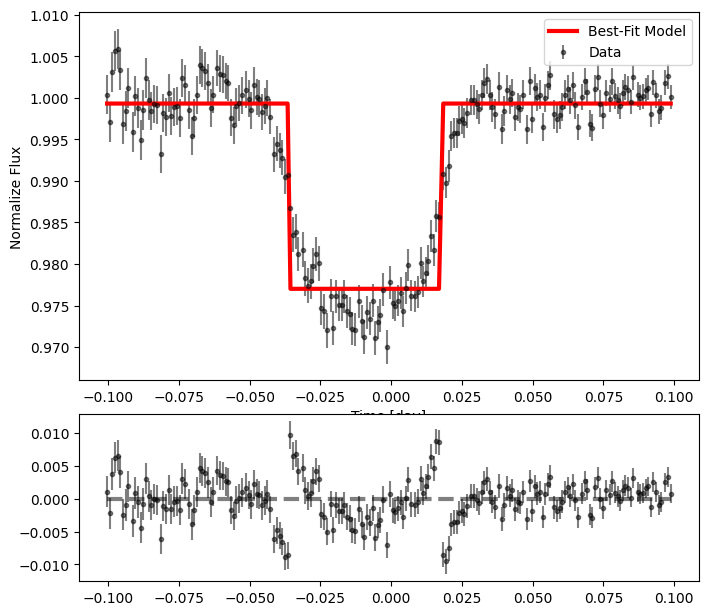

In [20]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux = np.percentile(flat_samples, 50, axis=0)
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [21]:
def calculate_reduced_Chi2(flux, model, err, num_parameters):
  degree_freedom = len(flux) - num_parameters
  rChi2 = np.sum((flux - model)**2 / err**2) / degree_freedom
  return(rChi2)

In [22]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 4))

Reduced Chi2 =  2.586656020547889


In [23]:
#Changes the model to a trapezoid
def trapezoid_model(t, center_time, duration, depth, delta_flux, ingress):
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0 + ingress))
  f[ind] = 1.0 + delta_flux
  ind = np.where((np.abs(t - center_time) <= (duration / 2.0 + ingress)) & (np.abs(t - center_time) > (duration / 2.0)))
  for i in ind[0]:
    delta_t = np.abs(np.abs(t[i] - center_time) - (duration / 2.0))
    f[i] = depth / ingress * delta_t + 1.0 + delta_flux - depth
  return(f)

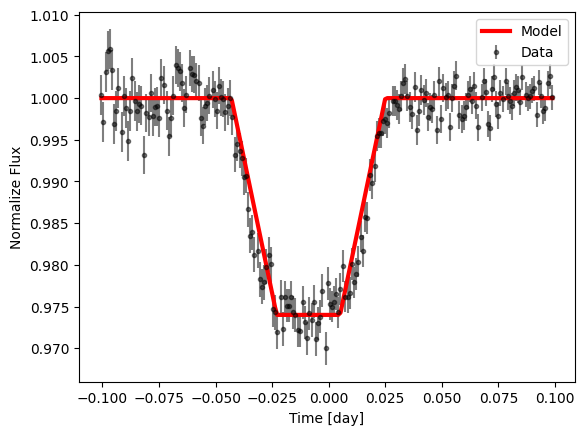

In [55]:
#Setting up the model data to best fit the data
center_time, duration, depth, delta_flux, ingress = -0.009, 0.028, 0.026, 0.0, 0.02
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [61]:
def calc_reduced_Chi2(O, C, err, n, m):
  Chi2 = np.sum((O - C)**2 / err**2)
  reduced_1Chi2 = Chi2 / (n - m)
  return(reduced_1Chi2)

In [63]:
print("reduced 1Chi2 = ", calc_reduced_Chi2(flux, model, err, len(time), 4.0))

reduced 1Chi2 =  1.3950981446684176


In [56]:
#Setting up data and filtering
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux, ingress = theta
    model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    center_time, duration, depth, delta_flux, ingress = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 \
      and -0.1 < delta_flux < 0.1 and 0.0 < ingress < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [64]:
import emcee

pos = np.array([-0.009, 0.028, 0.026, 0.0, 0.02]) + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:56<00:00, 42.87it/s]


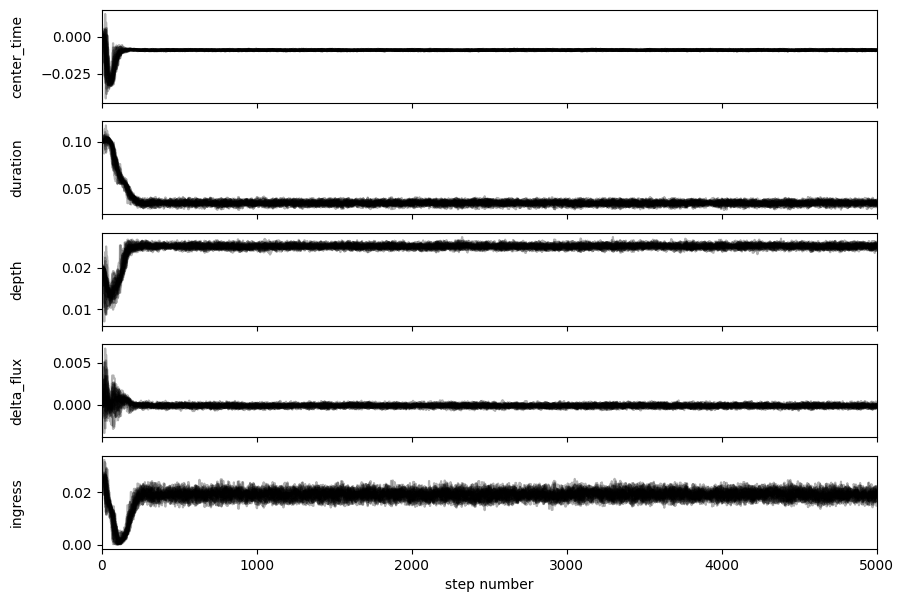

In [27]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux", "ingress"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(3136, 5)


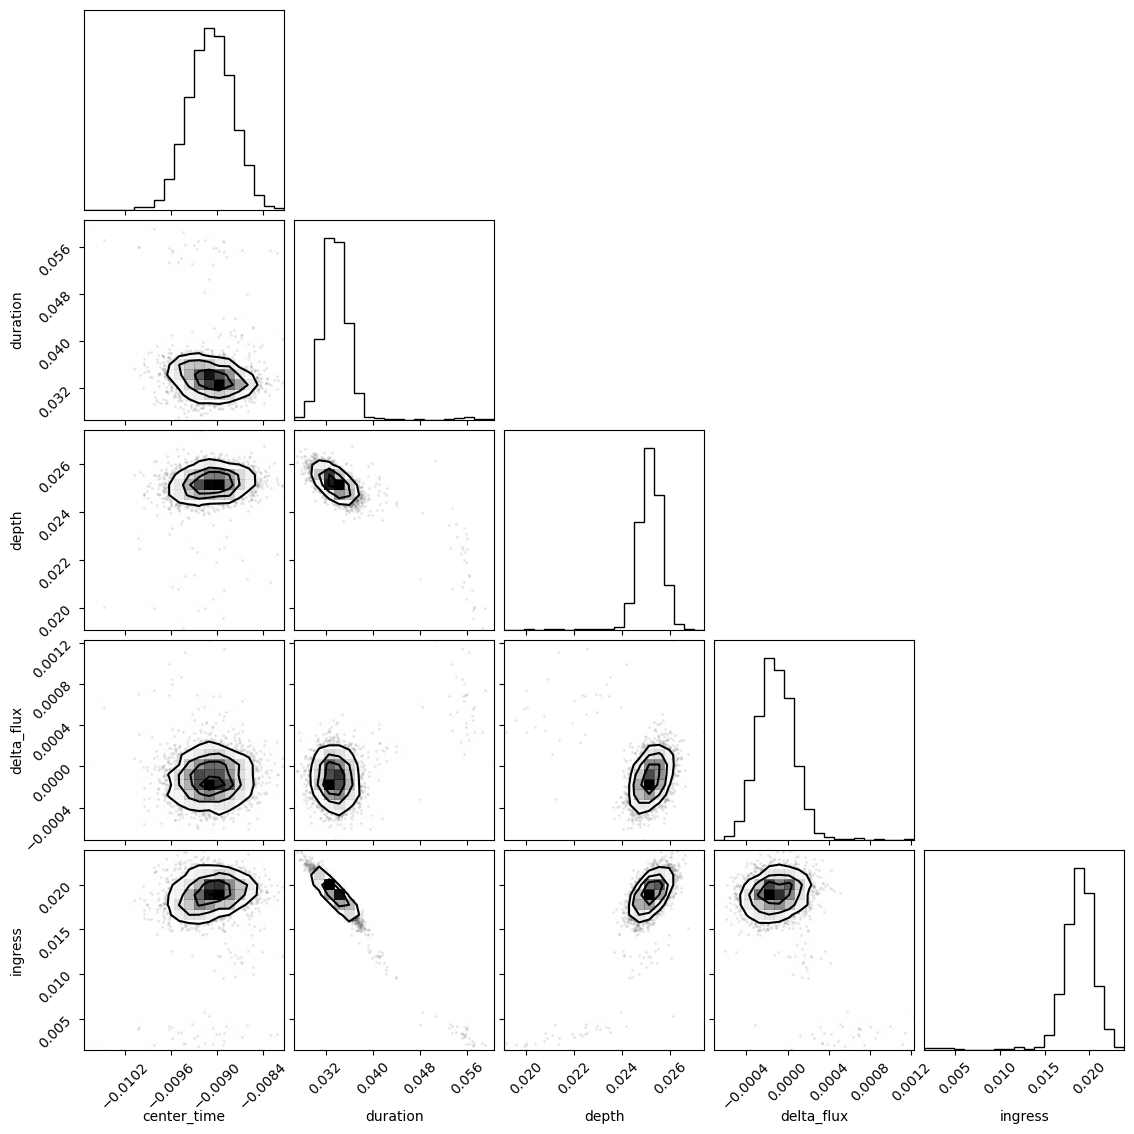

In [28]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels);

In [29]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

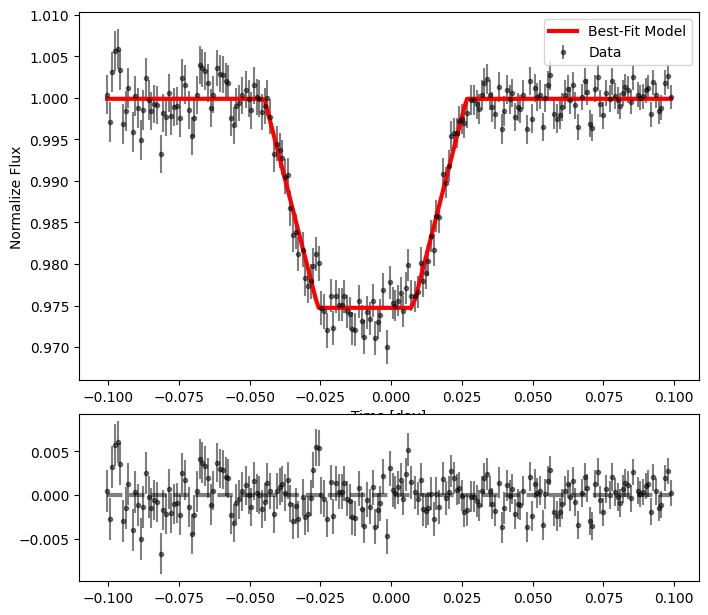

In [30]:
#Making the model best fit the data using the trapezoid model this time
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux, ingress = np.percentile(flat_samples, 50, axis=0)
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [31]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 5))

Reduced Chi2 =  1.1140804443277812
